In [1]:
### Plotting Prevalences for Wastewater and Clincal Data

On this page, we'll show how to plot lineage prevalences by creating a heatmap and an area plot that can be made using either wastewater or clinical data. Make sure the Python-outbreak-data package is up-to-date and import all necessary plotting and data analysis packages. Here are the packages and settings we used for this plot:

In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.dates as mdates

matplotlib.rcParams['hatch.linewidth'] = 0.5
matplotlib.rcParams['font.family'] ='sans-serif'
locator = mdates.MonthLocator(bymonthday=1)

/tmp/ipykernel_944290/1798173422.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from outbreak_data import outbreak_data
from outbreak_tools import outbreak_tools

Authenticate your credentials in GISAID if you haven't done so yet.

In [5]:
from outbreak_data import authenticate_user
authenticate_user.authenticate_new_user()

Please open this url in a web browswer and authenticate with your GISAID credentials:  https://gpsapi.epicov.org/epi3/gps_authenticate/UCOYDGOAXCGRVOALYVTOCMIXFOQOUMQHQLSEBLGWGKQHMDMNPHKVVYUYWVELASBRAWAWMXIQGULJPQTFUXXPSUXIXKXXQNEEDKXBRUMZKLNAVFUMOGTTSEPMSXZOYLPK
Waiting for authorization response... [Press Ctrl-C to abort]
Authenticated successfully!

    TERMS OF USE for Python Package and
    Reminder of GISAID's Database Access Agreement
    Your ability to access and use Data in GISAID, including your access and
    use of same via R Package, is subject to the terms and conditions of
    GISAID's Database Access Agreement (“DAA”) (which you agreed to
    when you requested access credentials to GISAID), as well as the
    following terms:
    1. You will treat all data contained in the R Package consistent with
    other Data in GISAID and in accordance with GISAID's Database Access
    Agreement;
    2. You will not distribute, or re-distribute Data made available through
    GIS

In [6]:
# Plots and saves figure 
def plot_out(fname):
    plt.savefig(fname, format='pdf', bbox_inches='tight')
    plt.show();

# Ensures plotted data is smoothed 
def binom_kernel(n, squeeze=0):
    return np.array([scipy.special.binom(n+2*squeeze, x) for x in np.arange(n)+squeeze])
    
smooth = binom_kernel(7*5, 35)

#### Pulling ww data

For our first plot, we're going to create a heatmap that shows the prevalence of multiple lineages collected from wastewater over time.  
To begin, we'll specify the location and date range for analysis and collect lineage data from the wastewater samples.

In [7]:
state = "California"
state_id = 'USA_US-CA'
startdate, enddate = "2023-09-02", "2024-01-02"
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate], server='dev.outbreak.info') #Get ww sample ids in a certain area 
ww_lineages = outbreak_data.get_wastewater_lineages(ww_samples, server='dev.outbreak.info')
ww_prevalences = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1], log=False)


#### Get the lineage tree data

In order to group the wastewater data properly for graphing, we need to get lineage data from the pre-parsed lineage tree (derived from the Pangolin project). This will help us organize and cluster lineage prevalence data. To do this, we're going to use an extension of outbreak_tools called outbreak_clustering. 

In [8]:
from outbreak_tools import outbreak_clustering
tree = outbreak_clustering.get_compressed_tree() # Gets the tree for lineages 
lineage_key = outbreak_clustering.get_lineage_key(tree)

Now we'll organize our previously retrieved sample data by date and site_id within our specified region to get the viral load smaple data.

In [9]:
samples_per_site = ww_samples['sra_accession'].groupby(ww_samples['collection_site_id']).nunique()

date_range_per_site = ww_samples.index.to_series().apply(pd.to_datetime).groupby(ww_samples['collection_site_id']) 
date_range_per_site = date_range_per_site.apply(lambda x: x.max() - x.min())

sites_for_vl = (date_range_per_site.apply(lambda x: x.days >= 14)) & (samples_per_site >= 3)
samples_for_vl = ww_samples[ww_samples['collection_site_id'].isin(list(sites_for_vl.index[sites_for_vl]))]

#### Cluster lineages using viral load data

Next we'll need to fetch and aggregate the weekly viral load sample data to get our wastewater prevalence data. 

In [10]:
viral_load = samples_for_vl.set_index(pd.Series(['viral_load'] * len(samples_for_vl)), append=True)
viral_load_weekly, _ = outbreak_tools.datebin_and_agg(viral_load, weights=viral_load['ww_population'].fillna(1000),
                                                                            startdate=startdate, enddate=enddate, freq='7D', column='normed_viral_load', norm=False, 
                                                                            rolling=[1,4,1], log=False, variance=True)
viral_load_weekly = viral_load_weekly['viral_load']

In [11]:
ww_prev_data = ww_prevalences.mul(viral_load_weekly, axis=0).sum()

Now we generate clustered groups given our prevalence data and lineage tree data.

In [12]:
clusters = outbreak_clustering.cluster_lineages(ww_prev_data, tree, lineage_key=lineage_key, n=10, alpha=0.25)

#### Prepare data for plotting

Now we want to apply these groups to our aggregated wastewater data. We'll focus on using weekly wastewater prevalences for this visual. However we can do the same using clinical data or daily wastewater data as well.

In [14]:
# This data is for weekly wastewater prevalences
clustered_ww_prevalences, _, _ = outbreak_tools.cluster_df(ww_prevalences.fillna(0), clusters, tree, lineage_key)

#### Plot A: Heatmap Wastewater Plot

Now that we've prepared our weekly wastewater prevalence data for plotting, we're almost ready to create our visual. Getting the date interval axes to look nice can be a little tricky.
Here we define how we want to format the plot's date axis. We created a function called format_dateinterval_axis() to save some time and code later on.

In [15]:
def format_dateinterval_axis(ax, index, every_n=4, narrow=0, shift=0, tickRight=False):
    months = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May', '06': 
              'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}
    def format(x, pos):
        side = lambda y: [y.mid, y.left, y.right][(x==0) + 2*(x==len(index)-1)]
        month = side(index.get_level_values(0)[x]).date().strftime('%m')
        pmonth = side(index.get_level_values(0)[x-1]).date().strftime('%m')
        return months[month] if month != pmonth else ''
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format))
    ax.set_xticks(np.arange(0, len(index), 1))
    ax.set_xlim(narrow+shift-0.5, len(index)-0.5-narrow+shift)
    ax.set_xlabel(None)
    if not tickRight:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['left', 'top']].set_visible(False)
        ax.yaxis.tick_right()

Now we create the heatmap:

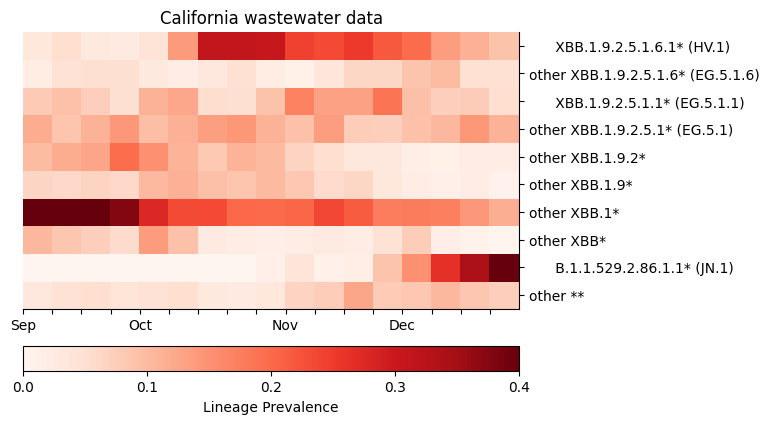

In [16]:
fig, ax = plt.subplots()
plt.pcolor(clustered_ww_prevalences.T, cmap='Reds', vmin=0, vmax=0.4)
plt.xticks(np.arange(0.5, len(clustered_ww_prevalences.index), 1), clustered_ww_prevalences.index)
plt.yticks(np.arange(0.5, len(clustered_ww_prevalences.columns), 1), clustered_ww_prevalences.columns)
format_dateinterval_axis(plt.gca(), clustered_ww_prevalences.index, shift=0.5, tickRight=True)
plt.title(f'{state} wastewater data')
cbar = plt.colorbar(location='bottom',pad = 0.1)
cbar.ax.set_xticks([0,0.1,0.2,0.3,0.4])
cbar.set_label('Lineage Prevalence')

plot_out('lin_prev_matrix_ww.pdf')

#### Plot B: Area Plots for Clinical and Wastewater Data

For the second plot, let's see how we can create area plots showing daily prevalence data for both wastewater and clinical data together for comparison. We'll need aggregated prevalence data from both clinical and wastewater samples in a given location.

Previously we worked with weekly wastewater data. Since we'll be comparing daily wastewater and clinical data, we need to pull and aggregate the daily wastewater and clincal prevalence data.

In [17]:
ww_prevalences = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1], log=False)
ww_prevalences_daily = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=smooth, log=False, variance=False)

#Including unsmoothed data
ww_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=1, log=False)

In [18]:
clinical_samples = outbreak_data.all_lineage_prevalences(location=state_id, other_threshold=0.0, nday_threshold=1, ndays=365)
clinical_prevalences = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1])
clinical_prev_data = clinical_prevalences.mul(viral_load_weekly, axis=0).sum()


clinical_prevalences = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1])
clinical_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=1, freq='D', log=False)
clinical_prevalences_daily = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=smooth, freq='D', log=False, variance=False)

In [19]:
clustered_cl_prevalences, root_lineages, isnatural = outbreak_tools.cluster_df(clinical_prevalences.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily_unsmoothed.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily.fillna(0), clusters, tree, lineage_key)

clustered_ww_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily_unsmoothed.fillna(0), clusters, tree, lineage_key)
clustered_ww_prevalences_daily, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily.fillna(0), clusters, tree, lineage_key)

Now we combine the plots in one frame, choose our colors, and set the date formatting and labels to visualize our data.

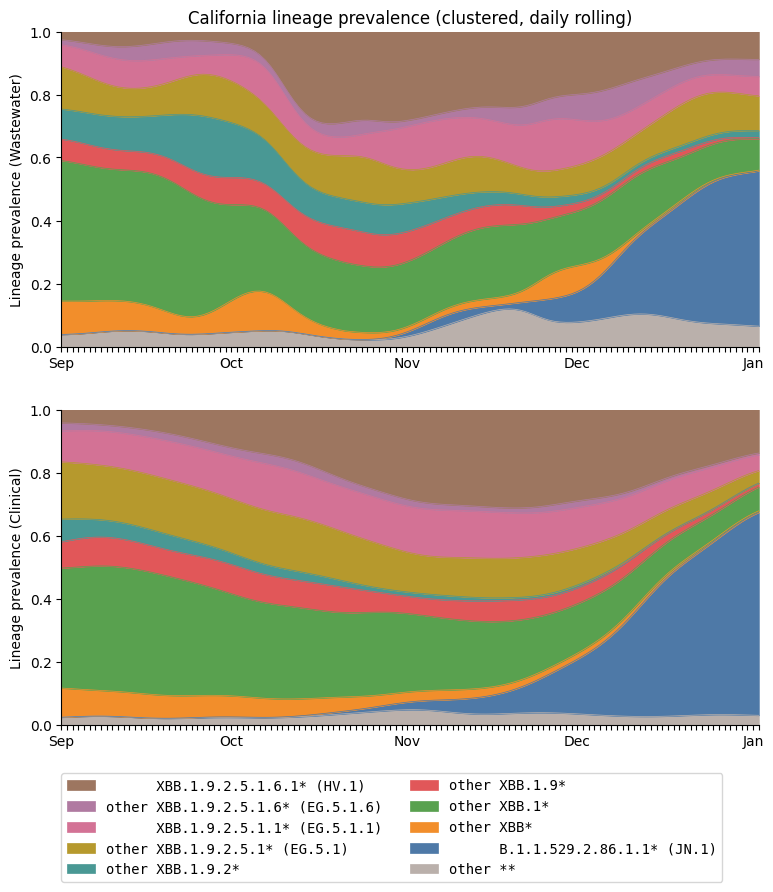

In [20]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(9,9))

#choose colors for each entry
cm = ["#bab0ab", "#4E79A7", "#f28e2b", "#59a14f","#e15759", "#499894","#B6992D",  "#D37295", "#B07AA1","#9D7660", "#bcbd22", "#aecBe8", "#FFBE7D",  "#8CD17D", "#FF9D9A",  "#86BCB6", "#F1CE63","#FABFD2",  "#D4A6C8", "#D7B5A6",  "#79706E"]


clustered_ww_prevalences_daily.plot(kind='area', stacked=True, color=cm[:len(clustered_ww_prevalences_daily)], linewidth=0.5, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Lineage prevalence (Wastewater)')
axs[0].spines[['right', 'top']].set_visible(False)

clustered_cl_prevalences_daily.plot(kind='area', stacked=True, color=cm[:len(clustered_cl_prevalences_daily)], linewidth=0.5, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('Lineage prevalence (Clinical)')
axs[1].spines[['right', 'top']].set_visible(False)

format_dateinterval_axis(axs[1], clustered_ww_prevalences_daily.index, narrow=0.5)
axs[1].legend(loc=(0,-0.5), prop={"family":"monospace"}, reverse=True, ncols=2)
axs[0].legend().remove()
axs[0].set_title(f'{state} lineage prevalence (clustered, daily rolling)')

axs[0].tick_params(axis='both', which='both',labelbottom=True)
axs[1].tick_params(axis='both', which='both')
plt.subplots_adjust(hspace=0.2)

plot_out('lin_prev_stacked_stacked.pdf')

We can also make similar combined plots for rolling daily prevalence values. 
Just use clustered daily wastewater and clinical prevalences.